In [82]:
import pandas as pd
import nltk
import warnings
import warnings
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


In [117]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

### Reading the data 

In [44]:
df = pd.read_csv("listings.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20230309202131,2023-03-10,previous scrape,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,...,5.00,5.00,5.00,NaN,f,1,1,0,0,0.08
1,8077,https://www.airbnb.com/rooms/8077,20230309202131,2023-03-10,city scrape,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,...,4.90,4.92,4.83,NaN,t,2,1,1,0,1.02
2,26654,https://www.airbnb.com/rooms/26654,20230309202131,2023-03-10,city scrape,World Class downtown @CN Tower Theatre MTCC ga...,"CN Tower, TIFF Bell Lightbox, Metro Convention...",There's a reason they call it the Entertainmen...,https://a0.muscache.com/pictures/81811785/5dcd...,113345,...,4.75,4.85,4.65,NaN,f,3,3,0,0,0.28
3,40456,https://www.airbnb.com/rooms/40456,20230309202131,2023-03-10,city scrape,Downtown- King Size Bed and Parking,---------------------Renovated and Newly Furn...,This is Nice Neighborhood located in Downtown ...,https://a0.muscache.com/pictures/b36b6ae3-20aa...,174063,...,4.96,4.57,4.68,NaN,f,4,4,0,0,0.74
4,27423,https://www.airbnb.com/rooms/27423,20230309202131,2023-03-10,city scrape,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,...,5.00,4.83,4.83,NaN,f,1,1,0,0,0.17


### Objective:

##### We wil try to predict the Price of the listing by the Given description. By Getting Answer of the following questions.

Question 1: How does the amount of description for a listing affect the price of a listing?

The quantity of description for a listing can potentially influence its price. While individual preferences may vary, the number of description can provide insights into the popularity and perceived value of a property. Typically, a higher number of description suggests a higher level details about the listings. This increased attention could potentially lead to a higher demand, which could be reflected in a higher price.

Moreover, the number of description can also contribute to building trust and credibility. Guests often rely on description to assess the quality and reliability of a property.
t
It's important to note that various factors can impact the price of a listing, and the number of description is just one of them. Other factors such as location, amenities, size, and market dynamics also play a significant role in determining the price of a property.

Question 2: Can we predict the price of a property based on the given descriptions?

Predicting the price of a property solely based on descriptions can be challenging. While descriptions provide valuable insights into listing itself,typically focus on aspects such as the quality of service, room size, amenities etc. These subjective factors are crucial, but may not directly correlate with the monetary value or pricing of a property.

To predict the price of a property accurately, it is necessary to consider a wide range of factors, including but not limited to location, property size, amenities, market conditions, and historical pricing data. Machine learning models can be employed to analyze various features and their impact on the price to generate predictions. However, relying solely on descriptions may not provide a comprehensive view for accurate price prediction.

While Airbnb and other platforms may leverage descriptions as part of their pricing algorithms, they typically incorporate multiple data points to estimate the optimal price for a listing. These algorithms often take into account factors like demand, seasonality, location, and historical booking patterns, in addition to descriptions.

In [45]:
airbnb = df[['description','price']] # here we try to predict price with given description
airbnb.head()

,description,price
0,"This large, family home is located in one of T...",$469.00
1,Guest room in a luxury condo with access to al...,$104.00
2,"CN Tower, TIFF Bell Lightbox, Metro Convention...",$145.00
3,---------------------Renovated and Newly Furn...,$150.00
4,"Brand new, fully furnished studio basement apa...",$45.00


In [46]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17997 entries, 0 to 17996
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  17751 non-null  object
 1   price        17997 non-null  object
dtypes: object(2)
memory usage: 281.3+ KB


In [47]:
import string
def count_punct(text): # function that counts the % of punctuation in the description
    if isinstance(text, str):
        count = sum([1 for char in text if char in string.punctuation])
        return round(count / (len(text) - text.count(" ")), 3) * 100
    else:
        return 0

# making 2 new features description length and punctuation percentage in description.
airbnb.loc[:, 'desc_len'] = airbnb['description'].apply(lambda x: len(x) - x.count(" ") if isinstance(x, str) else 0)
airbnb.loc[:, 'punct%'] = airbnb['description'].apply(lambda x: count_punct(x))

In [48]:
airbnb.price.unique() # lets take a look at the prices and what kind of special charaters they have

array(['$469.00', '$104.00', '$145.00', '$150.00', '$45.00', '$90.00',
       '$100.00', '$142.00', '$185.00', '$170.00', '$138.00', '$83.00',
       '$485.00', '$60.00', '$160.00', '$126.00', '$79.00', '$140.00',
       '$105.00', '$55.00', '$91.00', '$214.00', '$96.00', '$130.00',
       '$139.00', '$40.00', '$66.00', '$189.00', '$520.00', '$128.00',
       '$86.00', '$80.00', '$125.00', '$200.00', '$169.00', '$73.00',
       '$144.00', '$219.00', '$300.00', '$221.00', '$166.00', '$92.00',
       '$175.00', '$329.00', '$207.00', '$70.00', '$134.00', '$95.00',
       '$88.00', '$120.00', '$75.00', '$311.00', '$1,021.00', '$85.00',
       '$109.00', '$76.00', '$141.00', '$74.00', '$49.00', '$93.00',
       '$184.00', '$250.00', '$58.00', '$196.00', '$118.00', '$225.00',
       '$304.00', '$31.00', '$260.00', '$187.00', '$463.00', '$264.00',
       '$361.00', '$50.00', '$249.00', '$89.00', '$389.00', '$72.00',
       '$116.00', '$380.00', '$97.00', '$33.00', '$267.00', '$110.00',
      

so we have '$' and ',' as special characters, must remove them and convert our target column into float

In [49]:
airbnb['price'] = airbnb['price'].str.replace('[$,]', '', regex=True).astype(float)

In [50]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17997 entries, 0 to 17996
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   description  17751 non-null  object 
 1   price        17997 non-null  float64
 2   desc_len     17997 non-null  int64  
 3   punct%       17997 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 562.5+ KB


In [51]:
airbnb.isnull().sum() #we have few null records as well lets drop them

description    246
price            0
desc_len         0
punct%           0
dtype: int64

In [52]:
airbnb.dropna(inplace=True) #dropping the null values

In [53]:
airbnb.isnull().sum() # ok looks good

description    0
price          0
desc_len       0
punct%         0
dtype: int64

### Data Visualization

In [41]:
uni_price

array([4.6900e+02, 1.0400e+02, 1.4500e+02, 1.5000e+02, 4.5000e+01,
       9.0000e+01, 1.0000e+02, 1.4200e+02, 1.8500e+02, 1.7000e+02,
       1.3800e+02, 8.3000e+01, 4.8500e+02, 6.0000e+01, 1.6000e+02,
       1.2600e+02, 7.9000e+01, 1.4000e+02, 1.0500e+02, 5.5000e+01,
       9.1000e+01, 2.1400e+02, 9.6000e+01, 1.3000e+02, 1.3900e+02,
       4.0000e+01, 6.6000e+01, 1.8900e+02, 5.2000e+02, 1.2800e+02,
       8.6000e+01, 8.0000e+01, 1.2500e+02, 2.0000e+02, 1.6900e+02,
       7.3000e+01, 1.4400e+02, 2.1900e+02, 3.0000e+02, 2.2100e+02,
       1.6600e+02, 9.2000e+01, 1.7500e+02, 3.2900e+02, 2.0700e+02,
       7.0000e+01, 1.3400e+02, 9.5000e+01, 8.8000e+01, 1.2000e+02,
       7.5000e+01, 3.1100e+02, 1.0210e+03, 8.5000e+01, 1.0900e+02,
       7.6000e+01, 1.4100e+02, 7.4000e+01, 4.9000e+01, 9.3000e+01,
       1.8400e+02, 2.5000e+02, 5.8000e+01, 1.9600e+02, 1.1800e+02,
       2.2500e+02, 3.0400e+02, 3.1000e+01, 2.6000e+02, 1.8700e+02,
       4.6300e+02, 2.6400e+02, 3.6100e+02, 5.0000e+01, 2.4900e

In [56]:
all_words = airbnb['description'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

### Question 1: How does the amount of description for a listing affect the price of a listing?
#### Length of description and Price 
lets get a quick check aboutour newly created features!

Text(0, 0.5, 'Price')

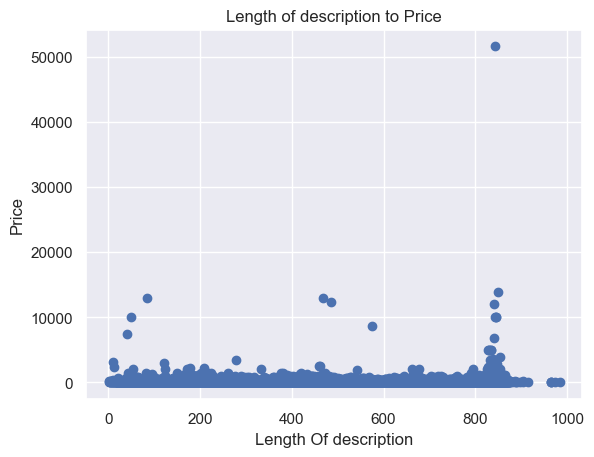

In [64]:
plt.scatter(airbnb["desc_len"], airbnb["price"])
plt.title("Length of description to Price")
plt.xlabel("Length Of description")
plt.ylabel("Price")

hmmm that didn't go as planned, it seem that interval of (0-150), (420-590) and (800-880) words has highter price

#### Punctuation % to Price

Text(0, 0.5, 'Price')

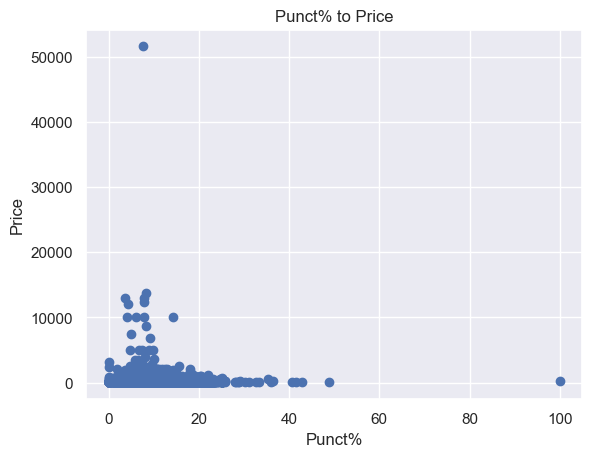

In [32]:
plt.scatter(airbnb["punct%"], airbnb["price"])
plt.title("Punct% to Price")
plt.xlabel("Punct%")
plt.ylabel("Price")

alright there's something! the lesser the punctuation % in the description the highter the prices at least relatively and to be more precisely it should be less than 20%.

### Question 2: Can we predict the price of a property based on the given descriptions?

In [65]:
# Import all my NLTK libraries
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

ps = PorterStemmer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords.words('english')]
    return text

# Let's first take a look at the clean data for visualization
clean_airbnb["description"] = airbnb['description'].apply(lambda x: clean_text(x))

Lets look at the top 50 cleaned data this time

In [121]:
cleaned_words = [word for sublist in clean_airbnb['description'] for word in sublist] # lets extract words

# Count the word frequencies
word_freq = Counter(cleaned_words)

# Get the top 50 most common words and their frequencies
top_50_words = dict(word_freq.most_common(50))

# Create a DataFrame from the top 50 word frequencies
df_top_words = pd.DataFrame(list(top_50_words.items()), columns=['Word', 'Frequency'])

#custom colors for the bar chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
fig = px.bar(df_top_words, x='Word', y='Frequency', title='Top 50 Word Frequencies (Clean Data)',
             color='Frequency', color_continuous_scale=colors)
fig.show()

<IPython.core.display.Javascript object>

### Now that we have take a look at the words and all lets move forwad with splitting the datatset

In [139]:
from sklearn.model_selection import train_test_split # split is 80:20

X_train, X_test, y_train, y_test = train_test_split(airbnb[['description', 'desc_len', 'punct%']], airbnb['price'], test_size=0.2)

In [143]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['description'])

tfidf_train = tfidf_vect_fit.transform(X_train['description'])
tfidf_test = tfidf_vect_fit.transform(X_test['description'])

X_train_vect = pd.concat([X_train[['desc_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['desc_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,desc_len,punct%,0,1,2,3,4,5,6,7,...,24772,24773,24774,24775,24776,24777,24778,24779,24780,24781
0,423,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,370,14.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,427,12.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,343,3.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Machine learning

In [167]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np

### Random Forest Regressor

In [171]:
# Convert column names to string
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

# Random Forest Regression
rf_regressor = RandomForestRegressor(n_jobs=-1)
rf_rmse_train_scores = np.sqrt(-cross_val_score(rf_regressor, X_train_vect[0:5000], y_train[0:5000], cv=3, scoring='neg_mean_squared_error'))
rf_regressor.fit(X_train_vect[0:5000], y_train[0:5000])
rf_predictions = rf_regressor.predict(X_test_vect)
rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_predictions))

# Evaluate Random Forest Regression
print("Random Forest Regression - Train RMSE scores:", rf_rmse_train_scores)
print("Random Forest Regression - Mean Train RMSE:", rf_rmse_train_scores.mean())
print("Random Forest Regression - Test RMSE:", rf_rmse_test)

Random Forest Regression - Train RMSE scores: [1275.62750138  224.79119311  174.58924188]
Random Forest Regression - Mean Train RMSE: 558.3359787916073
Random Forest Regression - Test RMSE: 421.4731770107212


In [172]:
# Random Forest Regression
rf_r2_train_scores = cross_val_score(rf_regressor, X_train_vect[0:5000], y_train[0:5000], cv=3, scoring='r2')
rf_regressor.fit(X_train_vect[0:5000], y_train[0:5000])
rf_predictions = rf_regressor.predict(X_test_vect)
rf_r2_test = r2_score(y_test, rf_predictions)

# Evaluate Random Forest Regression
print("Random Forest Regression - Train R2 scores:", rf_r2_train_scores)
print("Random Forest Regression - Mean Train R2:", rf_r2_train_scores.mean())
print("Random Forest Regression - Test R2:", rf_r2_test)

Random Forest Regression - Train R2 scores: [0.00092838 0.11361768 0.04856697]
Random Forest Regression - Mean Train R2: 0.05437100942874221
Random Forest Regression - Test R2: -0.2847825729141993
